In [2]:
import numpy as np
import glob
import csv
from rapidfuzz.string_metric import normalized_levenshtein
import utils
import forces
import funcs
import moleculegraph
import molecule
import matplotlib.pyplot as plt
from scipy.constants import R

In [3]:
# new coordinates without CCCCCCC....bäääh
name = "_test_aua_ps2_UA_off"
paths = sorted(glob.glob("sec*/tors_*/*.00.xyz"))
#paths = sorted(glob.glob("non*/tors_*/*.00.xyz"))
#print(paths)
# sort and stuff...
angles = []
coos = []
energies = []
for path in paths:
    xyz,energy = funcs.read_xyz(path,energy=True)
    xyz = funcs.assign_CHx(xyz)
    funcs.to_xyz(xyz,path.replace(".00.xyz","_clean.xyz"))
    xyz,energy = funcs.read_xyz(path,energy=True)
    xyz = funcs.kill_CHx(xyz)
    funcs.to_xyz(xyz,path.replace(".00.xyz","_kill.xyz"))
    #print( float(path.split("/")[1].split("_")[1]), energy  )
    angles.append(float(path.split("/")[1].split("_")[1]))
    coos.append(xyz)
    energies.append(energy)

print(xyz)
i=1
for x in xyz:
    print(utils.distance(xyz[i]["xyz"],xyz[x]["xyz"]))
    
xyz = funcs.read_xyz("test2.xyz")
print(xyz)
i=3
for x in xyz:
    print(utils.distance(xyz[i]["xyz"],xyz[x]["xyz"]))

{0: {'atom': 'H', 'xyz': array([ 0.4129505, -0.5788884, -2.3029306])}, 1: {'atom': 'O', 'xyz': array([-0.2035467, -0.413814 , -1.5823186])}, 2: {'atom': 'C', 'xyz': array([ 0.4105744,  0.4633885, -0.6384385])}, 3: {'atom': 'C', 'xyz': array([-0.4105743,  0.4633886,  0.6384386])}, 4: {'atom': 'O', 'xyz': array([ 0.2035467, -0.413814 ,  1.5823186])}, 5: {'atom': 'H', 'xyz': array([-0.4129504, -0.5788878,  2.3029309])}}
0.9626006491204957
0.0
1.4274237614133618
2.396686748400875
3.19071365746715
3.894388648590479
{0: {'atom': 'C', 'xyz': array([13.3522667 , 25.74653279, 21.81904403])}, 1: {'atom': 'C', 'xyz': array([13.45543874, 25.92389804, 23.54690314])}, 2: {'atom': 'C', 'xyz': array([14.22964033, 27.13374094, 24.02553458])}, 3: {'atom': 'O', 'xyz': array([13.24421557, 28.10385471, 24.34836165])}, 4: {'atom': 'H', 'xyz': array([12.83579963, 28.5283264 , 23.57769947])}}
3.4592035649087602
2.332201119393103
1.42
0.0
0.9700000000000011


8.314462618  J/mol/K


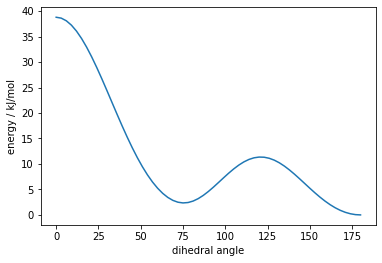

In [4]:
idx  = np.argsort(np.array(angles))
angles = np.array(angles)[idx]
energies = ( np.array(energies)[idx] - np.min(energies) )*2625.5 # hartree
coos = np.array(coos)[idx]

plt.plot(angles,energies)
plt.xlabel("dihedral angle")
plt.ylabel("energy / kJ/mol")
print(R," J/mol/K")

8.314462618


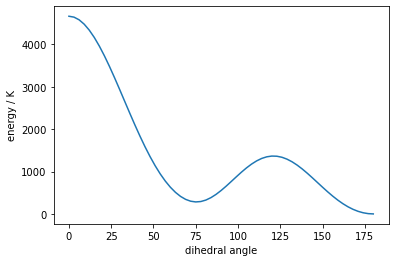

In [5]:
energies = energies/R*1000
plt.plot(angles,energies)
plt.xlabel("dihedral angle")
plt.ylabel("energy / K")
print(R)

In [6]:
#pair_pots = funcs.read_pair_potentials(glob.glob("UA_devel/pair_potentials")[0])
#angle_pots = funcs.read_angle_potentials(glob.glob("UA_devel/angle_potentials")[0])
#torsion_pots = funcs.read_torsion_potentials(glob.glob("UA_devel/torsion_potentials")[0])

pth = "UA_devel_2022"
pair_pots = funcs.read_pair_potentials(glob.glob(pth+"/pair_potentials")[0])
angle_pots = funcs.read_angle_potentials(glob.glob(pth+"/angle_potentials")[0])
torsion_pots = funcs.read_torsion_potentials(glob.glob(pth+"/torsion_potentials")[0])

In [21]:
eth12 = np.array(["cH_alcohol","OH_alcohol","CH2_alcohol","CH2_alcohol","OH_alcohol","cH_alcohol"])
eth = molecule.molecule(eth12)

paths = sorted(glob.glob("sec*/tors_*/*_clean.xyz"))
paths = sorted(glob.glob("sec*/tors_*/*_kill.xyz"))
#paths = sorted(glob.glob("non*/tors_*/*_kill.xyz"))
#paths = sorted(glob.glob("non*/tors_*/*_clean.xyz"))
#print(paths)

what=np.array([
    [0,4],
    [0,5],
    [0,3],
    [1,4],
    [1,5],
    [1,3],
    #[2,3],
    #[2,4],
    #[2,5],
    [0,1,2],
    [1,2,3],
    [2,3,4],
    [3,4,5],
    [0,1,2,3],
    [2,3,4,5],
    [1,2,3,4]
])

reftor = [1,2,3,4]
aa = [  int(eth.get_index(n))  for n in reftor ]

uatoms = [ [ eth.molecule[eth.get_index(n)] for n in w] for w in what ]
ens = []
angs = []
fpair = []
fbend = []
ftors = []
for path in paths:
    xyz = eth.assign_xyz_coos(path)
    print(path)
    force = 0
    fp = 0
    fb = 0
    ft = 0
    for ua,w in zip(uatoms,what):
        if len(w)==2:
            #print("pair")
            dist = utils.distance(xyz[w[0]]["xyz"],xyz[w[1]]["xyz"])
            #for u in ua:
            #    if u=="OH_alcohol":
            #        dist+=0.01
            print("dist: ",dist)
            if dist<148.0:
                f =  forces.mieq(dist, pair_pots[ua[0]],pair_pots[ua[1]]   ) 
                force += f
                fp += f
        elif len(w)==3:
            #print("angle")
            ang = utils.angle_between(xyz[w[0]]["xyz"],xyz[w[1]]["xyz"],xyz[w[2]]["xyz"])
            a = "_".join(ua)
            b = "_".join(np.flip(ua))
            if a in angle_pots:
                f = forces.bend( ang, angle_pots[ a] ) 
                force += f
                fb += f
            elif b in angle_pots:
                f = forces.bend( ang, angle_pots[ b] ) 
                force += f
                fb += f
            else:
                print("ERROR?: missing angle ",a)
        elif len(w)==4:
            tor = utils.dihedral(xyz[w[0]]["xyz"],xyz[w[1]]["xyz"],xyz[w[2]]["xyz"],xyz[w[3]]["xyz"])
            tor = tor/180*np.pi
            #print(tor)            
            a = "_".join(ua)
            b = "_".join(np.flip(ua))
            if a in torsion_pots:
                #f = forces.torsion_types( tor, torsion_pots[ a],key=torsion_pots[ a]["type"] )   
                f = forces.torsion( tor, torsion_pots[ a] )
                force += f
                ft += f
            elif b in torsion_pots:
                #f = forces.torsion_types( tor, torsion_pots[ b],key=torsion_pots[ b]["type"] )   
                f = forces.torsion( tor, torsion_pots[ b] )
                force += f
                ft += f
            else:
                print("ERROR?: missing torsion ",a)
        print(force)
    print(path)
    #print(force)
    ens.append(force)
    fpair.append(fp)
    fbend.append(fb)
    ftors.append(ft)
    #angs.append(float(path.split("/")[1].split("_")[1] ))
    #angs.append(float(path.split("_")[-2]))
    #print(aa)
    #print(xyz)
    angs.append(utils.dihedral(xyz[aa[0]]["xyz"],xyz[aa[1]]["xyz"],xyz[aa[2]]["xyz"],xyz[aa[3]]["xyz"]))
            
      

<ipython-input-21-64484e98cc6d>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  what=np.array([


sec_torsion/tors_0.00/tors_0_kill.xyz
dist:  3.5158397320488004
3.5158397320488004 0.0 -12480.790952057318
-12480.790952057318
dist:  4.4768744001905
4.4768744001905 0.0 6092.06147133762
-6388.729480719698
dist:  3.2725394257646
3.2725394257646 0.0 5074.672757331238
-1314.0567233884594
dist:  2.5540994000007067
2.5540994000007067 1721.8753993682617 27641.739844967513
28049.558520947314
dist:  3.5158397319793204
3.5158397319793204 0.0 -12480.790952303963
15568.76756864335
dist:  2.4433166008792577
2.4433166008792577 23417.160537436874 -10935.664427096182
28050.26367898404
1.8809879224555004
28051.23587072884
1.9327505126729432
28123.54128003761
1.9327505126734952
28195.846689344726
1.8809879225319455
28196.81888111238
28011.828882545182
27826.838882999957
29149.408882999935
sec_torsion/tors_0.00/tors_0_kill.xyz
sec_torsion/tors_102.00/tors_102_kill.xyz
dist:  3.9295681610404087
3.9295681610404087 0.0 -11166.738663980908
-11166.738663980908
dist:  4.719989076940964
4.719989076940964 0.0 

1.8860814595196413
30078.027374054913
1.9254527272861668
30173.886245540918
1.9254527272861668
30269.745117026923
1.8860814595196413
30272.836155894314
30093.79624868196
29914.756341469605
30396.84565699121
sec_torsion/tors_27.00/tors_27_kill.xyz
sec_torsion/tors_3.00/tors_3_kill.xyz
dist:  3.516180284999263
3.516180284999263 0.0 -12479.582148799713
-12479.582148799713
dist:  4.4771519094110275
4.4771519094110275 0.0 6091.683864487434
-6387.8982843122785
dist:  3.272253633467207
3.272253633467207 0.0 5075.115969425497
-1312.782314886782
dist:  2.554542435908302
2.554542435908302 1717.3097308937138 27636.94592057323
28041.473336580162
dist:  3.516180289468936
3.516180289468936 0.0 -12479.582132936008
15561.891203644154
dist:  2.4430279278736258
2.4430279278736258 23455.109407607903 -10936.956606805934
28080.04400444612
1.8810641395240049
28081.039113852734
1.9326545542305995
28153.632717447752
1.932654550334567
28226.226332755454
1.8810641706244446
28227.221451568133
28042.45950523057
2

34560.325593157206


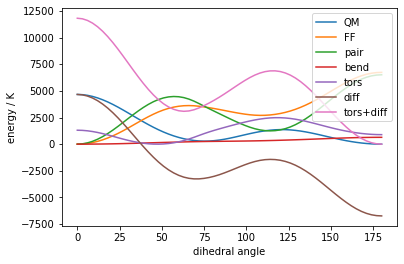

In [22]:
print(max(fpair))
angs = np.absolute(np.array(angs))
idx  = np.argsort(np.array(angs))
angs = np.array(angs)[idx]
ens = np.array(ens)[idx] - min(ens)
fpair = np.array(fpair)[idx] - min(fpair)
fbend = np.array(fbend)[idx] - min(fbend)
ftors = np.array(ftors)[idx] - min(ftors)
test = energies-ens+ftors
test = test - np.min(test)

plt.plot(angles,energies,label="QM")
plt.plot(angs,ens,label="FF")
plt.plot(angs,fpair,label="pair")
plt.plot(angs,fbend,label="bend")
plt.plot(angs,ftors,label="tors")
plt.plot(angles,energies-ens,label="diff")
plt.plot(angles,test,label="tors+diff")
plt.legend()
plt.xlabel("dihedral angle")
plt.ylabel("energy / K")
plt.savefig("forcetest"+name+".png")
plt.show()
plt.show()

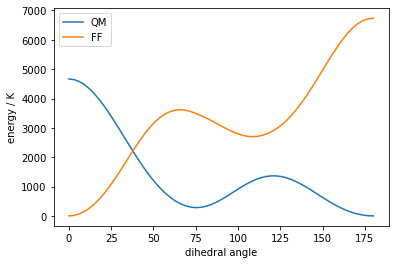

In [23]:
plt.plot(angles,energies,label="QM")
plt.plot(angs,ens,label="FF")
plt.legend()
plt.xlabel("dihedral angle")
plt.ylabel("energy / K")
plt.savefig("forcetest"+name+".png")
plt.show()
plt.show()

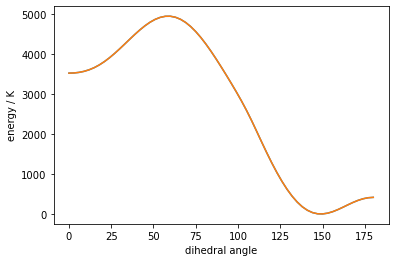

In [14]:
enpot  = energies-ens
enpot -= min(enpot)
plt.plot(angles,np.flip(enpot))
plt.plot(np.flip(angles),enpot)
plt.xlabel("dihedral angle")
plt.ylabel("energy / K")
#plt.title("With AUA from Diol paper. Without caring about Hs.")
plt.savefig("codetest"+name+".png")
plt.show()

In [9]:
a=[1,2,4]
a = {1:2}
isinstance(a, dict)

True

In [10]:
from scipy.optimize import curve_fit,minimize

class torsion_fit():
    def __init__(self,enpot,tor):
        self.enpot=enpot
        self.tor = tor
        
    def f(self,p):
        return np.sum((self.enpot - forces.torsion( self.tor, p))**2)


In [11]:
p0 = np.array([503.24,0.00,-251.62,1006.47])
f = torsion_fit(enpot,angs/180*np.pi)
xx = minimize(f.f,p0)
yy = forces.torsion( angs/180*np.pi, xx.x)

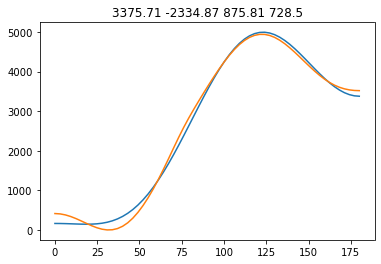

In [12]:
plt.plot(angs,yy)
plt.plot(angs,enpot)
plt.title(" ".join([str(round(x,2)) for x in xx.x] ))
plt.savefig("torsion"+name+".png")
plt.show()

In [14]:
paths

['sec_torsion/tors_0.00/tors_0_kill.xyz',
 'sec_torsion/tors_102.00/tors_102_kill.xyz',
 'sec_torsion/tors_105.00/tors_105_kill.xyz',
 'sec_torsion/tors_108.00/tors_108_kill.xyz',
 'sec_torsion/tors_111.00/tors_111_kill.xyz',
 'sec_torsion/tors_114.00/tors_114_kill.xyz',
 'sec_torsion/tors_117.00/tors_117_kill.xyz',
 'sec_torsion/tors_12.00/tors_12_kill.xyz',
 'sec_torsion/tors_120.00/tors_120_kill.xyz',
 'sec_torsion/tors_123.00/tors_123_kill.xyz',
 'sec_torsion/tors_126.00/tors_126_kill.xyz',
 'sec_torsion/tors_129.00/tors_129_kill.xyz',
 'sec_torsion/tors_132.00/tors_132_kill.xyz',
 'sec_torsion/tors_135.00/tors_135_kill.xyz',
 'sec_torsion/tors_138.00/tors_138_kill.xyz',
 'sec_torsion/tors_141.00/tors_141_kill.xyz',
 'sec_torsion/tors_144.00/tors_144_kill.xyz',
 'sec_torsion/tors_147.00/tors_147_kill.xyz',
 'sec_torsion/tors_15.00/tors_15_kill.xyz',
 'sec_torsion/tors_150.00/tors_150_kill.xyz',
 'sec_torsion/tors_153.00/tors_153_kill.xyz',
 'sec_torsion/tors_156.00/tors_156_kill.xy

In [20]:
torsion_pots

{'CHxx_alkane_CH2_alkane_CH2_alkane_CHxx_alkane': {'list': ['CHxx_alkane',
   'CH2_alkane',
   'CH2_alkane',
   'CHxx_alkane'],
  'type': 1,
  'p': [0.0, 355.03, -68.19, 791.32, 0.0]},
 'CH2_alkane_CH2_alcohol_OH_alcohol_cH_alcohol': {'list': ['CH2_alkane',
   'CH2_alcohol',
   'OH_alcohol',
   'cH_alcohol'],
  'type': 1,
  'p': [-184.99, 82.0, 36.89, 303.85, 0.0]},
 'CH2_alcohol_CH2_alcohol_OH_alcohol_cH_alcohol': {'list': ['CH2_alcohol',
   'CH2_alcohol',
   'OH_alcohol',
   'cH_alcohol'],
  'type': 1,
  'p': [-184.99, 82.0, 36.89, 303.85, 0.0]},
 'CHxx_alkane_CH2_alkane_CH2_alcohol_OH_alcohol': {'list': ['CHxx_alkane',
   'CH2_alkane',
   'CH2_alcohol',
   'OH_alcohol'],
  'type': 1,
  'p': [0.0, 206.45, -222.56, 1085.08, 0.0]},
 'CH2_alcohol_CH2_alkane_CH2_alcohol_OH_alcohol': {'list': ['CH2_alcohol',
   'CH2_alkane',
   'CH2_alcohol',
   'OH_alcohol'],
  'type': 6,
  'p': [1982.46,
   -3696.94,
   -741.73,
   1038.91,
   -225.06,
   4248.93,
   1077.08,
   -1323.58,
   0.0]},
 'CH